In [1]:
# pip install pandas scikit-learn torch pytorch-lightning

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [24]:
df = pd.read_csv("submission_df.csv")
df.head()

,WTeamID,LTeamID,gender,Wins_sum_w,GamesPlayed_sum_w,AvgScore_mean_w,AvgScore_std_w,AvgDayNum_mean_w,WinRatio_mean_w,WinRatio_std_w,...,AvgMargin_mean_l,AvgMargin_std_l,Possession_Control_mean_l,Possession_Control_std_l,Shooting_Efficiency_mean_l,Shooting_Efficiency_std_l,Assist_Ratio_mean_l,Assist_Ratio_std_l,Balanced_Score_mean_l,Balanced_Score_std_l
0,1101,1102,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,-0.31,6.45,24.14,9.10,0.57,0.16,0.40,0.15,9.97,3.68
1,1101,1103,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,5.13,3.50,28.44,8.54,0.55,0.13,0.35,0.12,11.67,3.44
2,1101,1104,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,5.21,3.89,31.41,9.30,0.54,0.13,0.32,0.12,12.85,3.75
3,1101,1105,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,-5.08,3.87,30.98,7.95,0.52,0.09,0.32,0.11,12.66,3.19
4,1101,1106,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,-2.56,4.73,28.89,10.26,0.50,0.14,0.30,0.13,11.82,4.14


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df.drop(columns=["WTeamID", "LTeamID", "gender"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = np.ones(len(X_scaled)) 
X_flipped = df.copy()

for col in df.columns:
    if "_w" in col:
        match = col.replace("_w", "")
        if f"{match}_l" in df.columns:
            X_flipped[col] = df[f"{match}_l"]
    elif "_l" in col:
        match = col.replace("_l", "")
        if f"{match}_w" in df.columns:
            X_flipped[col] = df[f"{match}_w"]

X_flipped = X_flipped.drop(columns=["WTeamID", "LTeamID", "gender"])
X_flipped_scaled = scaler.transform(X_flipped)
y_flipped = np.zeros(len(X_flipped_scaled))  
X_final = np.vstack([X_scaled, X_flipped_scaled])
y_final = np.hstack([y, y_flipped])

shuffle_idx = np.random.permutation(len(X_final))
X_final, y_final = X_final[shuffle_idx], y_final[shuffle_idx]
sequence_length = 5
num_features = X_final.shape[1]

cut_len = (X_final.shape[0] // sequence_length) * sequence_length

X_seq = X_final[:cut_len].reshape(-1, sequence_length, num_features)
y_seq = y_final[:cut_len].reshape(-1, sequence_length)[:, -1] 
X_seq = X_seq.transpose(0, 2, 1)  
X_seq.shape, y_seq.shape


((52562, 34, 5), (52562,))

In [ ]:
import numpy as np
from scipy.signal import convolve

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def causal_conv1d(x, weight, bias, dilation):
    in_channels, seq_len = x.shape
    out_channels, _, kernel_size = weight.shape
    output = np.zeros((out_channels, seq_len))

    for o in range(out_channels):
        for i in range(in_channels):            
            kernel = weight[o, i]
            dilated_kernel = np.zeros((dilation * (kernel_size - 1) + 1,))
            dilated_kernel[::dilation] = kernel[::-1]  
            conv_result = convolve(x[i], dilated_kernel, mode='full')[:seq_len]
            output[o] += conv_result
        output[o] += bias[o]
    return output

class TCN:
    def __init__(self, input_channels, hidden_channels, kernel_size=3, dilation=1, output_size=1):
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.output_size = output_size
    
        self.conv1_weight = np.random.randn(hidden_channels, input_channels, kernel_size) * 0.1
        self.conv1_bias = np.zeros(hidden_channels)

        self.fc_weight = np.random.randn(output_size, hidden_channels) * 0.1
        self.fc_bias = np.zeros((output_size, 1))

    def forward(self, x_seq):
        conv_out = causal_conv1d(x_seq, self.conv1_weight, self.conv1_bias, self.dilation)
        conv_out = relu(conv_out)

        gap = np.mean(conv_out, axis=1, keepdims=True)

        y_hat = sigmoid(self.fc_weight @ gap + self.fc_bias)
        return y_hat

sample_batch = X_seq[:1][0]  
sample_label = y_seq[:1]

input_channels = sample_batch.shape[0]  
hidden_channels = 32
output_size = 1
kernel_size = 3
dilation = 1

tcn_model = TCN(input_channels, hidden_channels, kernel_size, dilation, output_size)
y_pred = tcn_model.forward(sample_batch)

print("TCN Output:", y_pred)

TCN Output: [[0.50314727]]


In [ ]:
class TCNWithSGD(TCN):
    def __init__(self, input_channels, hidden_channels, kernel_size=3, dilation=1, output_size=1, learning_rate=0.01):
        super().__init__(input_channels, hidden_channels, kernel_size, dilation, output_size)
        self.lr = learning_rate

    def forward(self, x_seq):
        x_seq = x_seq.T  
        self.x_seq = x_seq
        self.conv_out = causal_conv1d(x_seq, self.conv1_weight, self.conv1_bias, self.dilation)
        self.relu_out = relu(self.conv_out)
        self.gap = np.mean(self.relu_out, axis=1, keepdims=True)  
        self.output = sigmoid(self.fc_weight @ self.gap + self.fc_bias)  
        return self.output

    def backward(self, y_true, y_pred):
        dy = y_pred - y_true  
        dWy = dy @ self.gap.T
        dby = dy
        dgap = self.fc_weight.T @ dy
        d_relu_out = np.ones_like(self.relu_out) * (dgap / self.relu_out.shape[1])
        d_conv_out = d_relu_out * (self.conv_out > 0)
        dW_conv = np.zeros_like(self.conv1_weight)
        db_conv = np.sum(d_conv_out, axis=1)

        for o in range(self.hidden_channels):
            for i in range(self.input_channels):
                for k in range(self.kernel_size):
                    for t in range(self.relu_out.shape[1]):
                        t_k = t - self.dilation * k
                        if 0 <= t_k < self.x_seq.shape[1]:
                            dW_conv[o, i, k] += d_conv_out[o, t] * self.x_seq[i, t_k]

        self.fc_weight -= self.lr * dWy
        self.fc_bias -= self.lr * dby
        self.conv1_weight -= self.lr * dW_conv
        self.conv1_bias -= self.lr * db_conv

    def train(self, X, y, epochs=10):
        log = []
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for i in range(len(X)):
                x_seq = X[i]  
                y_true = y[i]
                y_pred = self.forward(x_seq)
                loss = binary_cross_entropy(np.array([y_true]), y_pred)
                total_loss += loss
                pred_label = 1 if y_pred > 0.5 else 0
                if pred_label == y_true:
                    correct += 1
                self.backward(y_true, y_pred)

            avg_loss = total_loss / len(X)
            accuracy = correct / len(X)
            log.append((epoch + 1, avg_loss, accuracy))
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
        return log
X_train_small = X_seq[:2000]  
X_train_small = np.transpose(X_train_small, (0, 2, 1))  
y_train_small = y_seq[:2000]

tcn_sgd = TCNWithSGD(input_channels=34, hidden_channels=32, kernel_size=3, dilation=1, output_size=1, learning_rate=0.01)
tcn_SGD_training_log = tcn_sgd.train(X_train_small, y_train_small, epochs=15)


Epoch 1/15 | Loss: 0.6960 | Accuracy: 49.90%
Epoch 2/15 | Loss: 0.6914 | Accuracy: 52.40%
Epoch 3/15 | Loss: 0.6902 | Accuracy: 53.25%
Epoch 4/15 | Loss: 0.6908 | Accuracy: 53.25%
Epoch 5/15 | Loss: 0.6925 | Accuracy: 53.05%
Epoch 6/15 | Loss: 0.6939 | Accuracy: 51.75%
Epoch 7/15 | Loss: 0.6947 | Accuracy: 51.35%
Epoch 8/15 | Loss: 0.6951 | Accuracy: 51.50%
Epoch 9/15 | Loss: 0.6959 | Accuracy: 51.10%
Epoch 10/15 | Loss: 0.6968 | Accuracy: 50.70%
Epoch 11/15 | Loss: 0.6971 | Accuracy: 51.20%
Epoch 12/15 | Loss: 0.6972 | Accuracy: 50.30%
Epoch 13/15 | Loss: 0.6971 | Accuracy: 50.25%
Epoch 14/15 | Loss: 0.6970 | Accuracy: 50.25%
Epoch 15/15 | Loss: 0.6971 | Accuracy: 50.10%


In [ ]:
class TCNWithAdam(TCN):
    def __init__(self, input_channels, hidden_channels, kernel_size=3, dilation=1, output_size=1, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(input_channels, hidden_channels, kernel_size, dilation, output_size)
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
    
        self.m = {
            'fc_weight': np.zeros_like(self.fc_weight),
            'fc_bias': np.zeros_like(self.fc_bias),
            'conv_weight': np.zeros_like(self.conv1_weight),
            'conv_bias': np.zeros_like(self.conv1_bias)
        }
        self.v = {
            'fc_weight': np.zeros_like(self.fc_weight),
            'fc_bias': np.zeros_like(self.fc_bias),
            'conv_weight': np.zeros_like(self.conv1_weight),
            'conv_bias': np.zeros_like(self.conv1_bias)
        }
        self.t = 0  

    def forward(self, x_seq):
        x_seq = x_seq.T  
        self.x_seq = x_seq
        self.conv_out = causal_conv1d(x_seq, self.conv1_weight, self.conv1_bias, self.dilation)
        self.relu_out = relu(self.conv_out)
        self.gap = np.mean(self.relu_out, axis=1, keepdims=True)
        self.output = sigmoid(self.fc_weight @ self.gap + self.fc_bias)
        return self.output

    def adam_update(self, param, grad, name):
        self.t += 1
        self.m[name] = self.beta1 * self.m[name] + (1 - self.beta1) * grad
        self.v[name] = self.beta2 * self.v[name] + (1 - self.beta2) * (grad ** 2)

        m_hat = self.m[name] / (1 - self.beta1 ** self.t)
        v_hat = self.v[name] / (1 - self.beta2 ** self.t)

        update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return param - update

    def backward(self, y_true, y_pred):
        dy = y_pred - y_true
        dWy = dy @ self.gap.T
        dby = dy
        dgap = self.fc_weight.T @ dy
        d_relu_out = np.ones_like(self.relu_out) * (dgap / self.relu_out.shape[1])
        d_conv_out = d_relu_out * (self.conv_out > 0)
        dW_conv = np.zeros_like(self.conv1_weight)
        db_conv = np.sum(d_conv_out, axis=1)

        for o in range(self.hidden_channels):
            for i in range(self.input_channels):
                for k in range(self.kernel_size):
                    for t in range(self.relu_out.shape[1]):
                        t_k = t - self.dilation * k
                        if 0 <= t_k < self.x_seq.shape[1]:
                            dW_conv[o, i, k] += d_conv_out[o, t] * self.x_seq[i, t_k]
       
        self.fc_weight = self.adam_update(self.fc_weight, dWy, 'fc_weight')
        self.fc_bias = self.adam_update(self.fc_bias, dby, 'fc_bias')
        self.conv1_weight = self.adam_update(self.conv1_weight, dW_conv, 'conv_weight')
        self.conv1_bias = self.adam_update(self.conv1_bias, db_conv, 'conv_bias')

    def train(self, X, y, epochs=10):
        log = []
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for i in range(len(X)):
                x_seq = X[i]  
                y_true = y[i]
                y_pred = self.forward(x_seq)

                loss = binary_cross_entropy(np.array([y_true]), y_pred)
                total_loss += loss

                pred_label = 1 if y_pred > 0.5 else 0
                if pred_label == y_true:
                    correct += 1

                self.backward(y_true, y_pred)

            avg_loss = total_loss / len(X)
            accuracy = correct / len(X)
            log.append((epoch + 1, avg_loss, accuracy))
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
        return log

tcn_adam = TCNWithAdam(input_channels=34, hidden_channels=32, kernel_size=3, dilation=1)
tcn_training_log = tcn_adam.train(X_train_small, y_train_small, epochs=15)

Epoch 1/15 | Loss: 0.6991 | Accuracy: 49.55%
Epoch 2/15 | Loss: 0.6958 | Accuracy: 49.95%
Epoch 3/15 | Loss: 0.6959 | Accuracy: 49.35%
Epoch 4/15 | Loss: 0.6945 | Accuracy: 51.10%
Epoch 5/15 | Loss: 0.6937 | Accuracy: 51.70%
Epoch 6/15 | Loss: 0.6938 | Accuracy: 51.30%
Epoch 7/15 | Loss: 0.6951 | Accuracy: 51.85%
Epoch 8/15 | Loss: 0.6961 | Accuracy: 51.75%
Epoch 9/15 | Loss: 0.6959 | Accuracy: 51.45%
Epoch 10/15 | Loss: 0.6961 | Accuracy: 51.70%
Epoch 11/15 | Loss: 0.6978 | Accuracy: 52.35%
Epoch 12/15 | Loss: 0.7001 | Accuracy: 51.85%
Epoch 13/15 | Loss: 0.7011 | Accuracy: 51.40%
Epoch 14/15 | Loss: 0.7015 | Accuracy: 51.75%
Epoch 15/15 | Loss: 0.7019 | Accuracy: 51.85%


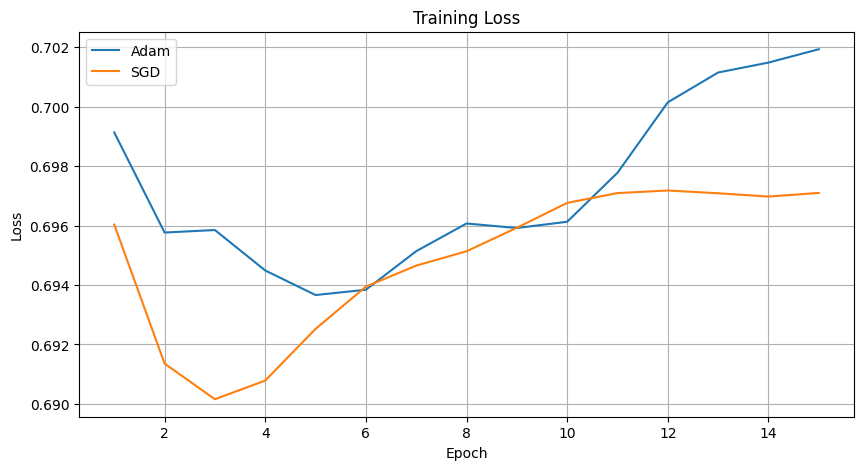

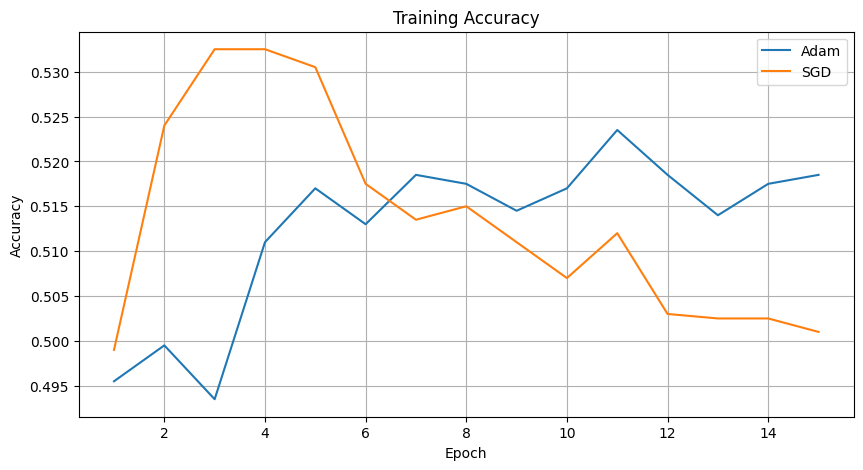

In [ ]:
import matplotlib.pyplot as plt

epochs_adam, losses_adam, accuracies_adam = zip(*tcn_training_log)  # For Adam
epochs_sgd, losses_sgd, accuracies_sgd = zip(*tcn_SGD_training_log) # For SGD (replace with SGD log)

plt.figure(figsize=(10, 5))
plt.plot(epochs_adam, losses_adam, label='Adam')
plt.plot(epochs_sgd, losses_sgd, label='SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_adam, accuracies_adam, label='Adam')
plt.plot(epochs_sgd, accuracies_sgd, label='SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Implementing the bi-directional LSTM

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

class BiLSTM:
    def __init__(self, input_dim, hidden_dim, output_dim=1, lr=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        
        self.Wf = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bf = np.zeros((hidden_dim, 1))
        self.Wi = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bi = np.zeros((hidden_dim, 1))
        self.Wc = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bc = np.zeros((hidden_dim, 1))
        self.Wo = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bo = np.zeros((hidden_dim, 1))
        
        self.Wf_b = np.copy(self.Wf)
        self.bf_b = np.copy(self.bf)
        self.Wi_b = np.copy(self.Wi)
        self.bi_b = np.copy(self.bi)
        self.Wc_b = np.copy(self.Wc)
        self.bc_b = np.copy(self.bc)
        self.Wo_b = np.copy(self.Wo)
        self.bo_b = np.copy(self.bo)

        self.Wy = np.random.randn(output_dim, 2 * hidden_dim) * 0.1
        self.by = np.zeros((output_dim, 1))

    def lstm_cell(self, x, h_prev, c_prev, Wf, bf, Wi, bi, Wc, bc, Wo, bo):
        concat = np.vstack((h_prev, x))
        ft = sigmoid(Wf @ concat + bf)
        it = sigmoid(Wi @ concat + bi)
        c_tilde = tanh(Wc @ concat + bc)
        c_next = ft * c_prev + it * c_tilde
        ot = sigmoid(Wo @ concat + bo)
        h_next = ot * tanh(c_next)
        return h_next, c_next

    def forward(self, x_seq):
        T, D = x_seq.shape
        h_fwd = np.zeros((self.hidden_dim, T))
        h_bwd = np.zeros((self.hidden_dim, T))

        h_prev_f = np.zeros((self.hidden_dim, 1))
        c_prev_f = np.zeros((self.hidden_dim, 1))
        h_prev_b = np.zeros((self.hidden_dim, 1))
        c_prev_b = np.zeros((self.hidden_dim, 1))
        
        for t in range(T):
            x_t = x_seq[t].reshape(-1, 1)
            h_prev_f, c_prev_f = self.lstm_cell(
                x_t, h_prev_f, c_prev_f,
                self.Wf, self.bf, self.Wi, self.bi,
                self.Wc, self.bc, self.Wo, self.bo
            )
            h_fwd[:, t] = h_prev_f.squeeze()
        
        for t in reversed(range(T)):
            x_t = x_seq[t].reshape(-1, 1)
            h_prev_b, c_prev_b = self.lstm_cell(
                x_t, h_prev_b, c_prev_b,
                self.Wf_b, self.bf_b, self.Wi_b, self.bi_b,
                self.Wc_b, self.bc_b, self.Wo_b, self.bo_b
            )
            h_bwd[:, t] = h_prev_b.squeeze()
        
        h_final = np.concatenate((h_fwd[:, -1], h_bwd[:, 0])).reshape(-1, 1)
        y_pred = sigmoid(self.Wy @ h_final + self.by)
        return y_pred

    def train(self, X, y, epochs=10):
        logs = []
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for i in range(len(X)):
                x_seq = X[i]  
                y_true = y[i]
                y_pred = self.forward(x_seq)

                loss = binary_cross_entropy(np.array([y_true]), y_pred)
                total_loss += loss

                pred_label = 1 if y_pred > 0.5 else 0
                if pred_label == y_true:
                    correct += 1

            avg_loss = total_loss / len(X)
            acc = correct / len(X)
            logs.append((epoch + 1, avg_loss, acc))
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc*100:.2f}%")
        return logs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4, dropout=0.5):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, 
                            bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):        
        lstm_out, _ = self.lstm(x)        
        out = lstm_out[:, -1, :]  
        out = self.fc(out)  
        out = self.sigmoid(out)
        return out

input_dim = 37  # Number of features 
hidden_dim = 30  # Number of LSTM units 
output_dim = 1  # Binary classification 
num_layers = 4  # Number of LSTM layers 
dropout = 0.5  # Dropout rate to prevent overfitting
learning_rate = 0.001  # Learning rate for optimizer

model = BiLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_seq = torch.randn(2000, 5, input_dim) 
y_seq = torch.randint(0, 2, (2000, 1)).float()  

dataset = TensorDataset(X_seq, y_seq)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

loss_list = []
acc_list = []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_loader.dataset)
    
    loss_list.append(avg_loss)
    acc_list.append(accuracy)

    print(f"Epoch {epoch+1}/10 | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")



Epoch 1/10 | Loss: 0.6940 | Accuracy: 48.90%
Epoch 2/10 | Loss: 0.6935 | Accuracy: 50.35%
Epoch 3/10 | Loss: 0.6931 | Accuracy: 50.75%
Epoch 4/10 | Loss: 0.6923 | Accuracy: 53.85%
Epoch 5/10 | Loss: 0.6906 | Accuracy: 55.00%
Epoch 6/10 | Loss: 0.6794 | Accuracy: 56.80%
Epoch 7/10 | Loss: 0.6644 | Accuracy: 59.70%
Epoch 8/10 | Loss: 0.6327 | Accuracy: 65.60%
Epoch 9/10 | Loss: 0.6062 | Accuracy: 66.50%
Epoch 10/10 | Loss: 0.5747 | Accuracy: 70.75%


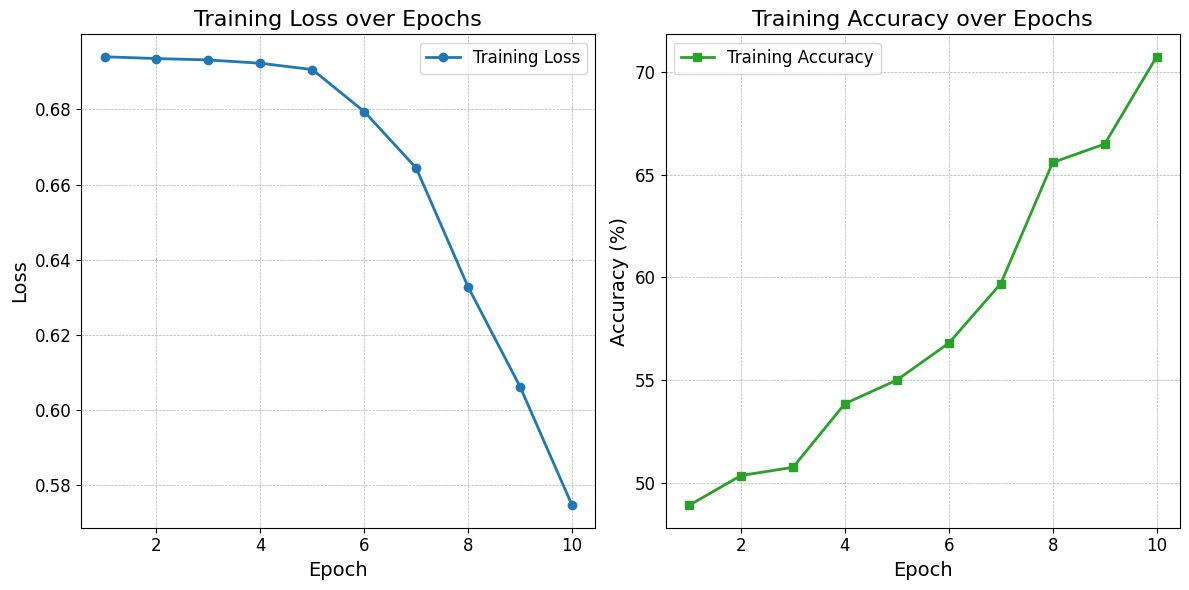

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_list) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, marker='o', color='#1f77b4', linewidth=2, markersize=6, label='Training Loss')
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in acc_list], marker='s', color='#2ca02c', linewidth=2, markersize=6, label='Training Accuracy')
plt.title('Training Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
